# Imports and inits consts

In [1]:
!rm -r ./reduce-mode-collapse-in-gan
!git clone -b stacked_mnist_experiment https://github.com/ThViviani/reduce-mode-collapse-in-gan.git

import sys; sys.path.append('./reduce-mode-collapse-in-gan')

rm: cannot remove './reduce-mode-collapse-in-gan': No such file or directory
Cloning into 'reduce-mode-collapse-in-gan'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 291 (delta 21), reused 34 (delta 11), pack-reused 242 (from 1)
Receiving objects: 100% (291/291), 5.38 MiB | 25.38 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [2]:
!pip install -r ./reduce-mode-collapse-in-gan/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 92.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 994.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━

In [3]:
import lightning as L
import torch
import torchvision
import torch.utils
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import torch_fidelity
import wandb
import gc
import pandas as pd

from PIL import Image
from torch.utils.data import Dataset
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer, seed_everything
from utils.utils import generate_some_examples

In [ ]:
BATCH_SIZE = 256
LATENT_SPACE_DIM = 128
WANDB_TOKEN = '' # input your wandb token
SEED = 999
MAX_EPOCHS = 100

seed_everything(SEED)

INFO: Seed set to 999


999

In [5]:
wandb.login(key=WANDB_TOKEN)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: developsviviani (developsviviani-clown-dev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Preparing StackedMnist dataset and loaders

In [6]:
transform = transforms.Compose([
    transforms.Pad(padding=2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5], [0.5]),
])

In [ ]:
from dataset_builders.stacked_mnist import StackedMNIST

train_dataset = StackedMNIST(root='MNIST/raw/train-images-idx3-ubyte', train=True, download=True, transform=transform)
val_dataset = StackedMNIST(root='MNIST/raw/train-images-idx3-ubyte', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 56808284.71it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1736339.05it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 14478842.25it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4384471.52it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/StackedMNIST/raw



In [8]:
img, target = train_dataset[0]

target:  tensor(364)


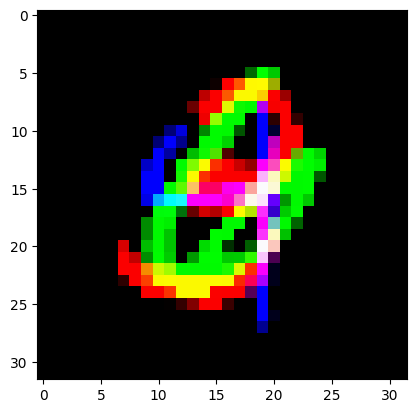

In [9]:
print('target: ', train_dataset[0][1])
plt.imshow(img.permute(1, 2, 0))

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

In [11]:
next(iter(train_loader))[0].shape

torch.Size([256, 3, 32, 32])

# Experiments

In [12]:
from models.discriminators import CriticStackedMNIST
from models.generators import GeneratorStackedMNIST


b = torch.randn(BATCH_SIZE, LATENT_SPACE_DIM)
g = GeneratorStackedMNIST(z_dim=LATENT_SPACE_DIM)
print(g(b).shape)


d = CriticStackedMNIST(x_factor=4)
d(torch.randn(256, 3, 32, 32), return_features=True)[1].shape

torch.Size([256, 3, 32, 32])


torch.Size([256, 8, 4, 4])

In [13]:
from models.encoders import EncoderMNIST

e = EncoderMNIST(x_shape=(3, 32, 32), z_dim=LATENT_SPACE_DIM, kernel_size=3, stride=2)

e(torch.randn(256, 3, 32, 32)).shape

torch.Size([256, 128])

In [14]:
train_dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor(364))

In [15]:
from utils.train_options import TrainOptions

train_options = TrainOptions(
    latent_dim=LATENT_SPACE_DIM,
    batch_size=BATCH_SIZE,
)

In [ ]:
from trainers.neighbors_embedding_gan import NEVanilaGAN, NERpGAN
from trainers.dist_gan import DistVanilaGAN, DistRpGAN
from trainers.standard_gan import StandardGAN
from trainers.rp_gan import RpGAN
from models.discriminators import CriticMNIST
from datetime import datetime
from trainers.dp_gan import DpVanilaGan, DpRpGAN
from trainers.ne_gan_without_ae import NEVanilaGAN_hat, NERpGAN_hat


def create_model_fn(model_class, use_encoder=False, use_r1r2=False):
    def wrapper():
        if model_class.__name__.find('Rp') != -1:
            return model_class(
                critic=CriticStackedMNIST(x_factor=2),
                generator=GeneratorStackedMNIST(z_dim=LATENT_SPACE_DIM),
                encoder=EncoderMNIST(x_shape=(3, 32, 32), z_dim=LATENT_SPACE_DIM, kernel_size=3, stride=2) if use_encoder else None,
                use_r1r2_penalty=use_r1r2,
                opt=train_options,
            )
        else:
            return model_class(
                critic=CriticStackedMNIST(x_factor=2),
                generator=GeneratorStackedMNIST(z_dim=LATENT_SPACE_DIM),
                encoder=EncoderMNIST(x_shape=(3, 32, 32), z_dim=LATENT_SPACE_DIM, kernel_size=3, stride=2) if use_encoder else None,
                opt=train_options,
            )
    return wrapper


EXPERIMENTS = {
    'DpVanilaGAN': create_model_fn(DpVanilaGan),
    'NEVanilaGAN': create_model_fn(NEVanilaGAN, use_encoder=True),
    'DistVanilaGAN': create_model_fn(DistVanilaGAN, use_encoder=True),
    'NEVanilaGAN_hat': create_model_fn(NEVanilaGAN_hat),
    'StandardGAN': create_model_fn(StandardGAN),
    'RpGAN': create_model_fn(RpGAN),
    'NERpGAN_hat': create_model_fn(NERpGAN_hat),
    'DistRpGAN': create_model_fn(DistRpGAN, use_encoder=True),
    'NERpGAN': create_model_fn(NERpGAN, use_encoder=True),
    'DpRpGAN': create_model_fn(DpRpGAN),
    'RpGAN_R1R2': create_model_fn(RpGAN, use_r1r2=True),
    'NERpGAN_hat+R1R2': create_model_fn(NERpGAN_hat, use_r1r2=True),
    'DistRpGAN+R1R2': create_model_fn(DistRpGAN, use_encoder=True, use_r1r2=True),
    'NERpGAN+R1R2': create_model_fn(NERpGAN, use_encoder=True, use_r1r2=True),
    'DpRpGAN+R1R2': create_model_fn(DpRpGAN, use_r1r2=True),
}

results = pd.DataFrame(columns=[
    'modes_covered',
    'KL',
])

In [17]:
import torch.nn.functional as F


def compute_kl_loss(true_labels, hat_labels, n_classes=1000):
    counts = torch.bincount(true_labels.int(), minlength=n_classes)
    p_real = (counts.float() / counts.sum())

    counts = torch.bincount(hat_labels.int(), minlength=n_classes)
    q = counts.float() / counts.sum()
    q = torch.log(q + 1e-12)
    
    kl_loss = nn.KLDivLoss(reduction="sum")
    output = kl_loss(q, p_real)
    return output.item() 

In [18]:
from tqdm.notebook import tqdm


def forward_wrapper_for_stacked_mnist_classifier(classifier, loader, device, confidence=0.95):
    results = []
    for batch in tqdm(loader):
        x, _ = batch
        x = x.to(device)
        classifier = classifier.to(device)
        
        labels = []
        exist_uncofident_label = False
        confidences = []
        for channel in range(3):
            digits_in_channel = x[:, channel, :, :].unsqueeze(dim=1)
            logits = classifier(digits_in_channel)
            p_logits = torch.nn.functional.softmax(logits).detach()
            channel_confidences, labels_hat = torch.max(p_logits, dim=1)
            labels.append(labels_hat)
            confidences.append(channel_confidences)
            
        accepted_labels = (confidences[0] > confidence) * (confidences[1] > confidence) * (confidences[2] > confidence) # хотя бы одну цифру неуверено классифицирует == даем общий лейбл 000
        result = 100 * labels[0] + 10 * labels[1] + labels[2]       
        results.extend(result * accepted_labels)
    return torch.Tensor(results)
    

def compute_modes_covered(preds_labels, n_classes=1000):
    modes_covered = torch.bincount(preds_labels.int(), minlength=n_classes)
    return (modes_covered > 0).sum().item()

In [19]:
from torch.utils.data import TensorDataset


def get_loader_from_generated_images(images, batch_size=256):
    dummy_labels = torch.zeros(images.shape[0])
    generated_dataset = TensorDataset(images, dummy_labels)

    loader = torch.utils.data.DataLoader(
        dataset=generated_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    return loader

In [ ]:
from models.utils import ResNet50OnMNIST

def compute_metrics(
    trainer,
    classifier=ResNet50OnMNIST(path_to_checkpoint='/kaggle/input/mnistclassifier/pytorch/default/1/resnet50_on_mnist_99.pth'), 
    n_samples=25600,
    confidence=0.95,
):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    z = torch.randn(n_samples, LATENT_SPACE_DIM, device=trainer.device)
    fake_images = trainer.generator(z)
    generated_loader = get_loader_from_generated_images(fake_images) 
    preds_labels = forward_wrapper_for_stacked_mnist_classifier(classifier.to(device), generated_loader, device, confidence)
    modes_covered = compute_modes_covered(preds_labels)
    kl_loss = compute_kl_loss(train_dataset.targets, preds_labels)
    return modes_covered, kl_loss  

In [ ]:
for name, model_fn in EXPERIMENTS.items():
    print(f"Running {name}")

    wandb_logger = WandbLogger(
        project='StackedMNIST_vkr',
        save_dir='',
        log_model=True,
        name=name + "_" + str(datetime.now())
    )

    trainer = L.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=wandb_logger,
        deterministic=True
    )

    model = model_fn()

    trainer.fit(model=model, train_dataloaders=train_loader)

    generate_some_examples(model.generator, BATCH_SIZE, LATENT_SPACE_DIM, model.device)
    metrics = compute_metrics(model)
    
    print(metrics)
    results.loc[name] = metrics

    wandb.finish()

    EXPERIMENTS[name] = model

    # del model
    del trainer
    del wandb_logger
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
results